In [1]:
import tabula
import numpy as np
import pymc as pm
import arviz as az
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from src.theory_sims import *
from tqdm.notebook import tqdm
import pandas as pd
import pytensor.tensor as at
import pyreadstat
from scipy.stats import norm
from scipy import stats
from src.figures import plot_prior_ppd
import os
%autosave 20



print('Creating output directories')
for directory in ["./output/", "./output/figures/", "./output/tables", "output/results", "output/generated", "output/tables"]:
    if not os.path.exists(directory):
        os.makedirs(directory)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Autosaving every 20 seconds
Creating output directories


# Analysis of replication efforts 

## Social Science Data Preparation 

To evaluate our model's predictions, we will leverage data from seven replicability efforts within the social sciences. Although each of these provide consolidated data, the format varies from .csv files to .pdfs, as does which features are included and which must be estimated. Our model solely requires knowing whether an outcome was significant and the associated sample size, such that we will extract these quantities. Moreover, we will only examine results for which the original study was significant at $p<.05$ in accordance with our model. Below, we briefly describe each dataset and the steps we took when extacting data. Once extracted, we save the generated data into `/generated/filename.csv`

### RPP Psychology (OSC 2015)

In [2]:
#papermill_description=DataWrangling

# Open File
rpp_data = pd.read_csv("dat/rpp_data.csv", encoding="latin1")

# Include all replications with original p-value < .05 and a replication p-value
rpp_data = rpp_data.dropna(subset=["T_pval_USE..R."])
rpp_data = rpp_data[rpp_data["T_pval_USE..O."] < 0.05]
# Extract relevant data
rpp_subset = pd.DataFrame(
    {
        "n": rpp_data["N (R)"],
        "Author": "OSC",
        "Year": 2015,
        "Sig": 1.0 * (rpp_data["T_pval_USE..R."].values < 0.05),
    }
)

# Save and display head
rpp_subset.to_csv("./output/generated/OSC2014.csv")
rpp_subset.head()


,n,Author,Year,Sig
0,29.0,OSC,2015,0.0
1,24.0,OSC,2015,0.0
2,32.0,OSC,2015,0.0
3,270.0,OSC,2015,0.0
4,48.0,OSC,2015,0.0


### Protzko Et al. 2023
Protzko Et al. 2023 is distinct from other replicability efforts in that it did not retrospectively survey the literature but instead took a prospective approach \cite{ProtzkoHighAchievable}. Briefly, a group of four labs engaged in rounds of pilot experiments to select sixteen studies which exhibited statistical significance. The selected studies were then subjected to a round of confirmation at larger sample sizes, $N\approx1500$. Of the confirmatory studies, 13 of 16 achieved statistical significance. 

Each of the hypotheses, regardless of the confirmatory study's outcomes were subjected to an additional four rounds of replication, of which one consisted of a self-replication. We used their publicly provided data for the analysis, and adapted their code to estimate significance (Data: \href{https://osf.io/xqw7e}, Code: \href{https://osf.io/k8er6}). As our model assumes a publication filter, we exclude the replications of studies for which the original finding was null. Moreover, we exclude self-replications as the remainder of data in our dataset consists of independent replications. This leaves 39 replications, of which 35 (89\%) were significant. 

It is worth noting that, at the time of our analysis there had been concerns raised regarding the published paper's ``preregistration and corresponding reporting of hypotheses, predictions, and analyses''. These concerns resulted in an editorial investigation, which at the time of writing remains ongoing. As these concerns do not relate to the integrity of the raw data, we felt inclusion was warranted regardless of the editorial investigations' outcome. 

In [3]:
# Open File
df_protzko = pd.read_csv("dat/Protzko2023.csv")

# Calculate full sample size
df_protzko["ne"] = df_protzko["n2750e"] + df_protzko["n1750e"]
df_protzko["nc"] = df_protzko["n2750c"] + df_protzko["n1750c"]
# Calculate variance
v_basic = (
    1 / df_protzko["ne"]
    + 1 / df_protzko["ne"]
    + df_protzko["d"] ** 2 / (2 * (df_protzko["N"] - 2))
)

# Loop through, using methods provided by Protko et all for estimating p-values.
temp = []
for idx in range(v_basic.shape[0]):
    if np.isnan(df_protzko["sefull"].iloc[idx]):
        temp.append(v_basic.iloc[idx])
    else:
        temp.append(df_protzko["sefull"].iloc[idx] ** 2)
df_protzko["v"] = temp
df_protzko["pval"] = 2 * (1 - norm.cdf(abs(df_protzko["d"] / np.sqrt(df_protzko["v"]))))

# #Identify studies for which the confirmation is significant, drop those.
originals = df_protzko[df_protzko["confirmation"] == 1]
studies_to_drop = originals[originals["pval"] > 0.05]["study"]
df_protzko = df_protzko[~df_protzko["study"].isin(studies_to_drop)]

# Include only independent replications.
df_protzko = df_protzko[df_protzko["selfrep"] == 0]
df_protzko = df_protzko[df_protzko["confirmation"] == 0]

# Extract relevant data
df_protzko_subset = pd.DataFrame(
    {
        "n": df_protzko["N"].values,
        "Author": "Protzko",
        "Year": 2023,
        "Sig": 1.0 * (df_protzko["pval"] < 0.05),
    }
)

# Save and display head
df_protzko_subset.to_csv("./output/generated/Protzko2023.csv")
df_protzko_subset.head()


,n,Author,Year,Sig
1,2163,Protzko,2023,1.0
2,2309,Protzko,2023,1.0
3,2282,Protzko,2023,1.0
6,1619,Protzko,2023,0.0
7,1892,Protzko,2023,1.0


### Soto 2019
Soto's 2019 paper evaluated replicability of links between personality traits and consequential life outcomes. This is considerably distinct as the survey evaluates associations between traits rather than the effect of some experimental outcome.  Of the 78 trait-outcome associations, 87% were significant. These associations were measured using surveys administered to two groups with a median $N=1504$. The provided data provide columns directly indicating what we need for our model so little transformation is needed beyond dropping rows with missing values or that were not originally significant.

In [4]:
df_soto, meta = pyreadstat.read_sav("dat/Soto2019.sav")


In [5]:
# load Soto2019.sav https://osf.io/erynzf
df_soto, meta = pyreadstat.read_sav("dat/Soto2019.sav")
df_soto = df_soto[df_soto["OriginalPValueByOutcome"] < 0.05]
df_soto.head()
df_soto.dropna(subset=["ReplicationSuccessByOutcome"], inplace=True)

# No significant reversals so we can assume sig==success, p-vals not provided.
soto_subset = pd.DataFrame(
    {
        "n": df_soto["ReplicationSampleSizeByOutcome"],
        "Author": "Soto",
        "Year": 2019,
        "Sig": df_soto["ReplicationSuccessByOutcome"] == 1,
    }
)

# There's some non 0/1 values in replicationsuccessbyoutcome based on suboutcomes so let's draw at random proportional to those
soto_subset["Sig"] = np.random.binomial(1, soto_subset["Sig"], soto_subset.shape[0])
soto_subset.to_csv("./output//generated/soto2019.csv")
soto_subset


,n,Author,Year,Sig
0,1559.0,Soto,2019,1
1,1559.0,Soto,2019,1
2,1550.0,Soto,2019,1
3,1514.0,Soto,2019,1
4,1514.0,Soto,2019,1
...,...,...,...,...
73,1505.0,Soto,2019,1
74,1505.0,Soto,2019,0
75,1505.0,Soto,2019,1
76,1505.0,Soto,2019,1


### Camerer 2016 
Camerer's 2016 paper evaluated the replicability of laboratory experiments in economics. The team replicated 18 studies published between 2011 and 2014 in either the American Economic Review and the Quarterly Journal of Economics. Of these 18 studies, 11 (61%) replicated at $p<.05$. We include all studies which were originally significant at $p<.05$ and for which required data are provided. This left 17 of the 18 original effects. The median replication sample size for these effects was 144. 

In [6]:
import pandas as pd

tables = tabula.read_pdf("dat/Camerer2016.pdf", pages="all")
tables[0].head()

# select 'Unnamed: 4', 'Replication', 'Unnamed: 5' 'Replicated', and rename 'p-value', d, N, 'replicated'
camerer_2016_raw = tables[0][["Unnamed: 4", "Replication", "Unnamed: 5", "Unnamed: 6"]]
camerer_2016_raw.columns = camerer_2016_raw.iloc[1]

# drop the first two rows (empty)
camerer_2016_raw = camerer_2016_raw.iloc[2:]
camerer_2016_raw["P-value"].replace("<0.001", 0.0009, inplace=True)

# Drop Ambrus and Greiner (not originally significant, index 3
camerer_2016_raw = camerer_2016_raw.drop(3)

camerer_2016_raw["P-value"] = camerer_2016_raw["P-value"].astype("float")
camerer_subset = pd.DataFrame(
    {
        "n": camerer_2016_raw["N"].values,
        "Author": "Camerer",
        "Year": 2016,
        "Sig": 1.0 * (camerer_2016_raw["P-value"].values < 0.05),
    }
)
camerer_subset.to_csv("./output/generated/camerer2016.csv")


Failed to import jpype dependencies. Fallback to subprocess.
No module named 'jpype'
Got stderr: Jun 07, 2024 8:51:07 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Jun 07, 2024 8:51:07 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>

/tmp/ipykernel_1165453/272341601.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  camerer_2016_raw["P-value"].replace("<0.001", 0.0009, inplace=True)


### Cova 2021
Cova et al's 2021 study examined the replicability of experimental philosophy \cite{Cova2021EstimatingPhilosophy}. For each year between 2003 and 2015, the authors selected three studies to replicate. Although one was the most cited paper of the year, two were selected at random. For consistency with our criteria, we include only the randomly selected hypotheses although note that they did not find substantial differences between the two groups. Replications were carried out at median $N=200$. In total, 20 out of 23 random replications achieved statistical significance. 

In [7]:
Xphi = pd.read_csv("./dat/XPhi.csv")

# Drop missing sample sizes or nonrandom
Xphi = Xphi.dropna(subset=["ReplicationN_Overall"])
Xphi = Xphi[Xphi["TYPE"] == "RANDOM"]

N = Xphi["ReplicationN_Overall"]
Sig = Xphi["ReplicationSUCCESS"] == "YES"

# Drop missing sample size rep

Xphi_subset = pd.DataFrame({"n": N, "Author": "Cova", "Year": 2021, "Sig": Sig})
Xphi_subset.to_csv("./output/generated/Xphi.csv")


### Camerer 2018

In [8]:
camerer_df = pd.read_csv("dat/Camerer2018.csv")

camerer_df = pd.read_csv("dat/Camerer2018.csv")
camerer_df.dropna(subset=["p_rp", "n_rp"], inplace=True)
camerer_df = camerer_df[camerer_df["p_os"] < 0.05]
cn = camerer_df["n_rp"].values
pn = camerer_df["p_rp"].values
# no reversals observed
camerer_subset = pd.DataFrame(
    {"n": cn, "Author": "Camerer", "Year": 2018, "Sig": 1.0 * (pn < 0.05)}
)
camerer_subset.to_csv("./output/generated/camerer2018.csv")
camerer_subset.head()

camerer_subset.head()


,n,Author,Year,Sig
0,599,Camerer,2018,0.0
1,14,Camerer,2018,1.0
2,243,Camerer,2018,1.0
3,65,Camerer,2018,1.0
4,92,Camerer,2018,1.0


### Boyce 2023
Boyce Et. al's 2023 paper summarizes the outcomes of student replications over eleven years. They argued that this sampling frame was more representative of the literature as it reflects the interest of practicing scientists, here their students. Their results consist of 176 replications spanning a wide range of topics, journals, and dates of the original paper including many studies conducted before and after widespread adoption of scientific reform. 


In [9]:
boyce_df = pd.read_csv("dat/Boyce2023.csv")


In [10]:
boyce_df = pd.read_csv("dat/Boyce2023.csv")
boyce_df.head()
boyce_df.dropna(subset=["rep_p_calc", "replication_N"], inplace=True)
boyce_df = boyce_df[boyce_df["p_orig"] < 0.05]
nb = boyce_df["replication_N"]

boyce_subset = pd.DataFrame(
    {
        "n": nb.values,
        "Author": "Boyce",
        "Year": 2023,
        "Sig": 1.0 * (boyce_df["rep_p_calc"].values < 0.05),
    }
)
boyce_subset.to_csv("./output/generated/boyce2023.csv")
boyce_subset


,n,Author,Year,Sig
0,88,Boyce,2023,0.0
1,225,Boyce,2023,0.0
2,40,Boyce,2023,0.0
3,209,Boyce,2023,0.0
4,198,Boyce,2023,0.0
...,...,...,...,...
66,56,Boyce,2023,0.0
67,37,Boyce,2023,0.0
68,17,Boyce,2023,1.0
69,160,Boyce,2023,0.0


## Statistical Model: Systematic Efforts 


### Step One: Conceptual Anaysis 
Our conceptual analysis here is based firmly in the theoretical model described at length in our manuscript. We need only adapt it slightly to account for the context in which replication efforts occur. Specifically, we assume that a given sampling frame may have a unique average effect size which is proportional to $\sqrt{\tau^2 + \sigma^2}$. Moreover, because there are only single replications of most hypotheses, it is impossible to disengangle $\sigma$ and $\tau$. Instead, we will focus on the total variation in observed hypothesis and its relationship to significance rather replication as defined by significance in the same direciton 

### Step Two: Define Observational Space
Our dataset consistes of a column indicating which replication effort a study came from, whether the results were significant and the sample size. Although we could calculate the observed effect sizes for many of the hypotheses, adds unnecesary complication as some effect sizes do not have an easy converstion Cohen's $d$. As our model provides a strict relationship between the probability of significance, sample size, and the distribution of observed effect sizes we will instead infer effect sizes. This has the added benefit of providing a sanity check that our model is reconstructing plausible effect size estimates. 

In [11]:
import glob

# Load Data
dfs = []
for file in glob.glob("./output/generated/*.csv"):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True).drop(columns=["Unnamed: 0"])
df["author_year"] = df["Author"] + df["Year"].astype("str")
df.head()


,n,Author,Year,Sig,author_year
0,29.0,OSC,2015,0.0,OSC2015
1,24.0,OSC,2015,0.0,OSC2015
2,32.0,OSC,2015,0.0,OSC2015
3,270.0,OSC,2015,0.0,OSC2015
4,48.0,OSC,2015,0.0,OSC2015


### Step Three: Construct Summary Statistics 
We'll be particularly interested in the rate at which significance was observed for each replication effort. 

### Step Four: Model Development 
As sample size and significance are known, we seek to estimate the distribution of observed hypotheses attribtable to $\sqrt{\tau^2 + \sigma^2}. We'll refer to this quantity as $v$. Assuming statistical tests are two-tailed, the probability of significance depends only on $\mid v \mid$ and $n$, such that we will treat $v$ as half-normally distributed corresponding to the absolute value of the unknown effect sizes one might see. Moreover, we will estimate $v$ hierachichcally across replication efforts. 

As our ourcomes are binary, we will assume that significance is as defined in our statistical model, namely the probability of significance for an arbitrary replication from a given samplign frame (i.e., $\text{Pr}(p<.05) = \theta$). As in our theoretical model, we assume this probability as though the researchers were conducting one-sample $z$-tests. 

This leads to our statistical model: 

\begin{align*}
y_i&\sim\text{Bernoulli}(\theta_i)\\
\theta_i&= 1 - Phi(z_i)\\
z_i &= d_i \sqrt{N_i}\\
d_i &\sim \text{HalfNormal}(\sqrt{\pi/2} v_{p[i]})\\
v_p &\sim \text{HalfNormal}(\bar{v})\\
\bar{v}&\sim \text{HalfNormal}(.5)
\end{align*}

Here, the $i^{th}$ outcome from the $p^{th}$ replication effort is defined by an unkown replication-averaged effect size $d_i$. We assume that $d_i$ is drawn from the study's sampling frame, which is half-normally distributed with an average effect size of $\sqrt{\pi/2} v_{s[i]}$. Note that the $\sqrt{\pi/2}$ is necessary to ensure that the expected value for $d$ (effect size) is the expected value for efffect sizes in $v_s$, given the expectation of a half-normal distribution. 

In [12]:
pidx, paper = pd.factorize(df["author_year"])
coords = {"paper": paper}

with pm.Model(coords=coords) as rep_efort_model:
    sig = pm.MutableData("sig", df["Sig"].astype("int").values)
    N_rep = pm.Data("N_rep", df["n"].values)
    value = pm.Data("value", stats.norm.ppf(0.975))
    p_idx = pm.Data("pidx", pidx)

    # Modeling the probability of significance
    var_bar = pm.TruncatedNormal("var_bar", mu=0.5, sigma=0.2, lower=0)
    var = pm.HalfNormal("var", sigma=var_bar, dims="paper")
    d_mu = pm.HalfNormal("d_mu", var[p_idx] * pm.math.sqrt(np.pi / 2), shape=len(df))

    rv = pm.Normal.dist(d_mu * pm.math.sqrt(N_rep), 1)
    theta = pm.Deterministic("theta", 0.99999 * (1 - pm.math.exp(pm.logcdf(rv, value))))
    y = pm.Bernoulli("y", theta, observed=sig)


/home/joseph/anaconda3/envs/rep_surveys/lib/python3.10/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


### Step Five: Construct Summary Functions 
We will examine the distribution of implied effect sizes as well as the probability that a replication is significant across the various replication efforts. 

### Step Six: Simulate Prior Ensemble 

In [13]:
with rep_efort_model:
    prior_rep_effort = pm.sample_prior_predictive(1000)


Sampling: [d_mu, var, var_bar, y]


### Step Seven: Prior Checks

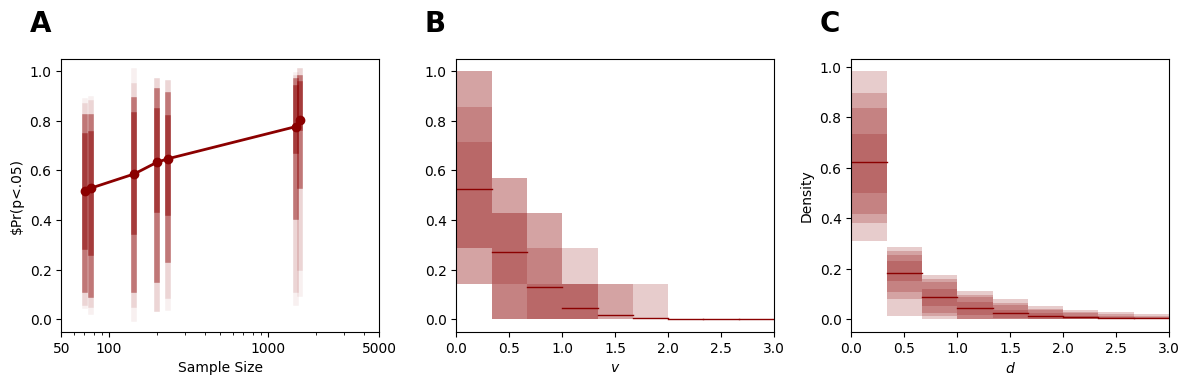

In [14]:
#papermill_description=priorChecks
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plt.sca(ax[0])
medians = []
ns = []
for p_idx in np.unique(pidx):
    prior_paper = prior_rep_effort.prior_predictive["y"][
        :, :, np.where(pidx == p_idx)[0]
    ]
    median_n = np.median(df[pidx == p_idx]["n"])
    median = np.median(np.mean(prior_paper, axis=1))
    widths = [1, 2, 4, 5]
    plt.scatter(median_n, median, color="darkred")
    medians.append(median)
    ns.append(median_n)
    for idx, percentile in enumerate([6, 11, 25, 50, 25]):
        low = np.percentile(np.mean(prior_paper, axis=2), percentile / 2, axis=1)
        high = np.percentile(np.mean(prior_paper, axis=2), 100 - percentile / 2, axis=1)

        plt.plot(
            [median_n, median_n],
            [low, high],
            lw=4,
            alpha=(percentile) / 100,
            color="darkred",
        )
order = np.argsort(ns)
plt.plot(np.array(ns)[order], np.array(medians)[order], color="darkred", lw=2)
# logx
plt.xscale("log")
# natural units
plt.xticks([50, 100, 1000, 5000], ["50", "100", "1000", "5000"])
plt.ylabel(r"$Pr(p<.05)")
plt.xlabel("Sample Size")

plt.sca(ax[1])
temp = prior_rep_effort.prior["var"].values.reshape(1000, -1)
plot_prior_ppd(temp, bins=np.linspace(0, 3, 10), ax=ax[1])
plt.xlabel(r"$v$")
plt.xlim(0, 3)

plt.sca(ax[2])
plt.ylabel("Density")
temp = prior_rep_effort.prior["d_mu"].values.reshape(1000, -1)
plot_prior_ppd(temp, bins=np.linspace(0, 3, 10), ax=ax[2])
plt.xlabel(r"$d$")
plt.xlim(0, 3)
plt.ylabel("Density")
from src.figures import label_subfigs

label_subfigs(ax)
plt.tight_layout()
plt.savefig("./output/figures/RepEffortPriorPredictive.png", dpi=300)


### Step Eight: Configure Algorithm

We will use 4000 samples as the chains seem slow to converge and set target_accept to .97 to deal with rare divergence issues. 

### Step Nine: Fit Simulated Ensemble
We would like to ensure that if our model were used to analyze a population of replication efforts we could successfully and reliably recover the underlying parameters. We'll fit our model to prior simulated data and check the algorthmic and inferential adequacy of our model. 

In [16]:
from src.util import check_diagnostics

rank_dicts = []
for j in range(30):
    prior_choice = np.random.choice(1000)

    sim_y = prior_rep_effort.prior_predictive["y"][0, prior_choice].values.ravel()
    with rep_efort_model:
        pm.set_data({"sig": sim_y})
        sim_trace = pm.sample(
           5000, tune=4000, return_inferencedata=True, target_accept=0.95
        )
        passsed = check_diagnostics(sim_trace, var_names=["var", "var_bar"])
        known_sigma = {
            "var": np.mean(prior_rep_effort.prior["var"].std(dim=("chain", "draw")))
        }
        for param in ["var"]:
            posterior_simmed = sim_trace.posterior[param]
            prior_value = prior_rep_effort.prior[param][0, prior_choice, :]
            # Get the rank of prior value for each posterior simulated value
            ranks = np.array(
                [
                    np.sum(
                        np.array(prior_value[idx]).ravel()
                        > np.array(posterior_simmed[0:, :, idx]).ravel()
                    )
                    for idx in range(prior_value.shape[0])
                ]
            )
            contraction = 1 - np.array(
                np.std(posterior_simmed, axis=(0, 1)) ** 2 / known_sigma[param] ** 2
            )
            z_score = (prior_value - np.mean(posterior_simmed, axis=(0, 1))) / np.std(
                posterior_simmed, axis=(0, 1)
            )
            rank_dicts.append(
                {
                    "prior": np.repeat(prior_choice, ranks.size),
                    "contraction": contraction,
                    "z_score": z_score,
                    "passed": np.repeat(passsed["success"], ranks.size),
                    "param": np.repeat(param, ranks.size),
                    "rank": ranks,
                }
            )

rank_df = pd.concat([pd.DataFrame(item) for item in rank_dicts])
rank_df.head()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 82 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1342.0
Min effective sample size(tail):  860.0
Min BFMI:  0.7983581671874248
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 80 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1489.0
Min effective sample size(tail):  1328.0
Min BFMI:  0.8366929922007091
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 91 seconds.


Total divergences:  0
Max Rhat:  1.01
Min effective sample size(bulk):  551.0
Min effective sample size(tail):  475.0
Min BFMI:  0.7800516956841643
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 86 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1901.0
Min effective sample size(tail):  3532.0
Min BFMI:  0.8391722623233989
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 84 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  2463.0
Min effective sample size(tail):  1868.0
Min BFMI:  0.8242588222820723
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 84 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1779.0
Min effective sample size(tail):  3464.0
Min BFMI:  0.8162100242971166
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 84 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1567.0
Min effective sample size(tail):  2893.0
Min BFMI:  0.8003388785360525
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 86 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1905.0
Min effective sample size(tail):  3629.0
Min BFMI:  0.8501400249883666
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 94 seconds.


Total divergences:  0
Max Rhat:  1.01
Min effective sample size(bulk):  517.0
Min effective sample size(tail):  447.0
Min BFMI:  0.7972293409805676
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 95 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Total divergences:  0
Max Rhat:  1.01
Min effective sample size(bulk):  309.0
Min effective sample size(tail):  166.0
Min BFMI:  0.7924175720384334
Bad diagnostics, increase tuning or check model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 85 seconds.


Total divergences:  0
Max Rhat:  1.01
Min effective sample size(bulk):  767.0
Min effective sample size(tail):  515.0
Min BFMI:  0.816375864881851
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 88 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1310.0
Min effective sample size(tail):  1854.0
Min BFMI:  0.8401549245350841
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 84 seconds.


Total divergences:  0
Max Rhat:  1.01
Min effective sample size(bulk):  835.0
Min effective sample size(tail):  770.0
Min BFMI:  0.8284681430833678
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 82 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  2094.0
Min effective sample size(tail):  3640.0
Min BFMI:  0.7773856535588257
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 85 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1499.0
Min effective sample size(tail):  2949.0
Min BFMI:  0.8485207995441985
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 82 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  3145.0
Min effective sample size(tail):  6124.0
Min BFMI:  0.8000419260476556
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 86 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1817.0
Min effective sample size(tail):  929.0
Min BFMI:  0.800267441992253
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 90 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  592.0
Min effective sample size(tail):  503.0
Min BFMI:  0.7874249270897429
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 84 seconds.


Total divergences:  0
Max Rhat:  1.01
Min effective sample size(bulk):  769.0
Min effective sample size(tail):  535.0
Min BFMI:  0.7729461079357685
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 92 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1462.0
Min effective sample size(tail):  1012.0
Min BFMI:  0.8000598766153169
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 93 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  710.0
Min effective sample size(tail):  651.0
Min BFMI:  0.8203512102588334
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 83 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1383.0
Min effective sample size(tail):  845.0
Min BFMI:  0.790413963780177
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 85 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1333.0
Min effective sample size(tail):  2380.0
Min BFMI:  0.80033937011372
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 84 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1452.0
Min effective sample size(tail):  1404.0
Min BFMI:  0.8109067939740215
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 81 seconds.


Total divergences:  0
Max Rhat:  1.01
Min effective sample size(bulk):  1312.0
Min effective sample size(tail):  620.0
Min BFMI:  0.8222382956733412
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Total divergences:  0
Max Rhat:  1.01
Min effective sample size(bulk):  952.0
Min effective sample size(tail):  619.0
Min BFMI:  0.8687208105497038
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 83 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1898.0
Min effective sample size(tail):  1437.0
Min BFMI:  0.7843309132880644
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 83 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  943.0
Min effective sample size(tail):  546.0
Min BFMI:  0.8247253929867193
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 84 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1828.0
Min effective sample size(tail):  4089.0
Min BFMI:  0.8002021180321943
Good diagnostics, continue


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 85 seconds.


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1453.0
Min effective sample size(tail):  2031.0
Min BFMI:  0.8443638567120392
Good diagnostics, continue


,prior,contraction,z_score,passed,param,rank
0,658,0.873878,0.939599,True,var,16691
1,658,0.999819,-1.471221,True,var,1251
2,658,0.997148,0.034090,True,var,10441
3,658,0.713644,-1.264417,True,var,425
4,658,0.766430,-0.877268,True,var,3487


#### Step Ten: Algorithmic Calibration
Let's check that our diagnostics are ubiquitously meeting criteria. The mean of our "passed" column should be 1.0, indicating that all simulated runs passed all algorthmic calibration criteria. 


In [ ]:
rank_df["passed"].mean()


0.9666666666666667

#### Step Eleven: Inferential Calibration
We're going to check some [standard plots](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html), to verify that our "true" prior values are uniformly distributed in the posterior (A, C) and that the contraction is high and there are no unexpectedly extreme z-scores. This provides assurances that our model is well identified, and not substantially under/over-fit and that our prior model is not overly restrictive or problematic in some other way.  

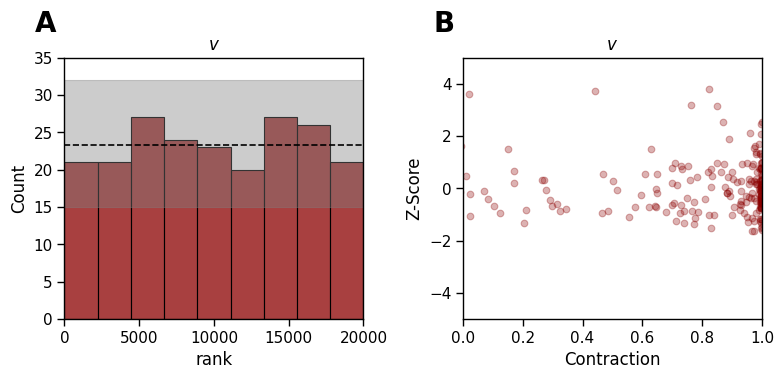

In [17]:
#papermill_description=InferentialCalibration

sns.set_context("paper", font_scale=1.25)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))


def rank_plot(temp, ax, bins=10):
    plt.sca(ax)
    sns.histplot(temp["rank"], color="darkred", bins=np.linspace(0, 20000, bins))
    expected = temp["rank"].shape[0] / (bins - 1)
    low = stats.binom(temp["rank"].shape[0], 1 / (bins - 1)).ppf(0.03)
    high = stats.binom(temp["rank"].shape[0], 1 / (bins - 1)).ppf(0.97)
    plt.fill_between([0, 20000], [low, low], [high, high], alpha=0.4, color="grey")
    plt.plot([0, 20000], [expected, expected], "k--")
    plt.xlim(0, 20000)
    plt.ylim(0, expected * 1.5)


def eye_test(temp, ax):
    plt.sca(ax)
    plt.scatter(temp["contraction"], temp["z_score"], alpha=0.3, color="darkred")
    plt.xlim(0, 1)
    plt.xlabel("Contraction")
    plt.ylabel("Z-Score")
    plt.xlim(0, 1)
    plt.ylim(-5, 5)


temp = rank_df[rank_df["param"] == "var"]
rank_plot(temp, ax[0])
plt.title(r"$v$")


plt.sca(ax[1])
eye_test(temp, ax[1])
plt.xlim(0, 1)
plt.title(r"$v$")


from src.figures import label_subfigs

label_subfigs(ax)
plt.tight_layout()
plt.savefig("output/figures/RepEffortEyeChart.png", dpi=300)


### Step Twelve: Fit the Observation

In [18]:
with rep_efort_model:
    pm.set_data({"sig": df["Sig"].astype("int").values})
    idata_rep_effort = pm.sample(5000, tune=4000, target_accept=0.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_bar, var, d_mu]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 85 seconds.


### Step Thirteen: Diagnose Posterior Fit

In [19]:
#papermill_description=PosteriorFit

check_diagnostics(idata_rep_effort)


/home/joseph/anaconda3/envs/rep_surveys/lib/python3.10/site-packages/arviz/utils.py:142: UserWarning: Items starting with ~: ['mu', 'alpha', 'B_raw'] have not been found and will be ignored
  warnings.warn(
/home/joseph/anaconda3/envs/rep_surveys/lib/python3.10/site-packages/arviz/utils.py:142: UserWarning: Items starting with ~: ['mu', 'alpha', 'B_raw'] have not been found and will be ignored
  warnings.warn(
/home/joseph/anaconda3/envs/rep_surveys/lib/python3.10/site-packages/arviz/utils.py:142: UserWarning: Items starting with ~: ['mu', 'alpha', 'B_raw'] have not been found and will be ignored
  warnings.warn(


Total divergences:  0
Max Rhat:  1.0
Min effective sample size(bulk):  1932.0
Min effective sample size(tail):  2700.0
Min BFMI:  0.7726446312383999
Good diagnostics, continue


{'Total divergences': array(0),
 'Max Rhat': 1.0,
 'Min effective sample size(bulk)': 1932.0,
 'Min effective sample size(tail)': 2700.0,
 'Min BFMI': 0.7726446312383999,
 'success': True}

### Step Fourteen: Posterior Retrodictive Checks

In [20]:
# Sample posterior predictive
with rep_efort_model:
    ppc = pm.sample_posterior_predictive(idata_rep_effort)
    idata_rep_effort.extend(ppc)


Sampling: [y]


Output()

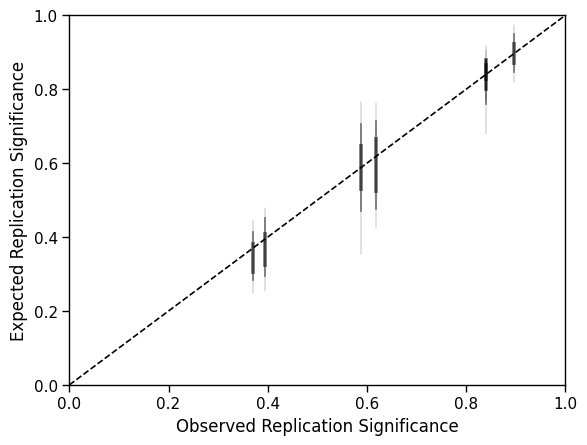

In [21]:

# Plot the observed vs expected significance
idata_rep_effort.posterior_predictive["y"]
studies = []
# groupby author_year and get mean of sig then create a list of studies

for idx, ay in enumerate(df.groupby("author_year")["Sig"].mean().sort_values().index):
    group = df[df["author_year"] == ay]
    post = idata_rep_effort.posterior_predictive["y"][:, :, group.index]

    observed = group["Sig"].sum() / group["Sig"].shape[0]
    # plt.scatter(np.sum(post,axis=2).median()/group[1].shape[0],idx,color='k')

    for q in [0.97, 0.89, 0.75, 0.5]:
        low = np.quantile(np.sum(post, axis=2), q) / group.shape[0]
        high = np.quantile(np.sum(post, axis=2), 1 - q) / group.shape[0]
        plt.plot(
            [observed, observed], [low, high], color="k", lw=(1 - q) * 11, alpha=0.5
        )

    median = np.median(np.sum(post, axis=2)) / group.shape[0]
    # plt.scatter([observed, ], [idx-.5, idx+.5], color='k',lw=1)

    studies.append(group)
# plt.yticks(range(len(studies)), studies)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], color="k", ls="--")
plt.xlabel("Observed Replication Significance")
plt.ylabel("Expected Replication Significance")
plt.savefig("./output/figures/RepEffortObservedVsExpected.png")


In [22]:
temp = idata_rep_effort.posterior['var'] * np.sqrt(2/np.pi)

#select not OSC2015
summary_table = az.summary(temp)
summary_table.index = [item[4:-1] for item in summary_table.index]

summary_table.to_latex('./output/tables/avgEffectTotal.tex',float_format="%.2f")

summary_table

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
OSC2015,0.152,0.024,0.109,0.199,0.000,0.000,4320.0,8370.0,1.0
Soto2019,0.215,0.063,0.117,0.335,0.001,0.001,1932.0,3437.0,1.0
Boyce2023,0.169,0.030,0.116,0.226,0.000,0.000,4248.0,8134.0,1.0
Protzko2023,0.292,0.128,0.100,0.527,0.003,0.002,2036.0,3698.0,1.0
Camerer2018,0.292,0.102,0.126,0.477,0.002,0.001,4263.0,7990.0,1.0
Cova2021,0.451,0.163,0.199,0.757,0.003,0.002,3380.0,5991.0,1.0
Camerer2016,0.236,0.089,0.100,0.400,0.001,0.001,5436.0,8084.0,1.0


In [23]:
temp = idata_rep_effort.posterior['var'] * np.sqrt(2/np.pi)

OSC2015 = temp.sel(paper='OSC2015')
temp = temp - OSC2015
#select not OSC2015
temp = temp.where(temp != 0).dropna('paper')
summary_table = az.summary(temp)
summary_table.index = [item[4:-1] for item in summary_table.index]

summary_table.to_latex('./output/tables/avgEffectContrast.tex',float_format="%.2f")

summary_table

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Soto2019,0.063,0.068,-0.055,0.188,0.002,0.001,2029.0,3276.0,1.0
Boyce2023,0.017,0.038,-0.055,0.089,0.001,0.000,4382.0,8213.0,1.0
Protzko2023,0.140,0.130,-0.057,0.388,0.003,0.002,2047.0,3904.0,1.0
Camerer2018,0.140,0.104,-0.032,0.335,0.002,0.001,4425.0,8188.0,1.0
Cova2021,0.298,0.165,0.031,0.602,0.003,0.002,3446.0,6675.0,1.0
Camerer2016,0.084,0.092,-0.068,0.252,0.001,0.001,5289.0,8328.0,1.0


## Analaysis

### Analaysis of replicability as a function of sample size. 
Below, we plot the observed rates of replication at the median sample size and compare that with the posterior predictive estimate of replication significance. To do so, we first take the median across our paper-wide estimates of $\sqrt{\sigma^2 + \tau^2}$. Next, we run this through our publication rate function setting it to tau. We note that the values of tau and sigma individually do not mattter for publication rate, such that setting sigma to zero produces no overall effect.

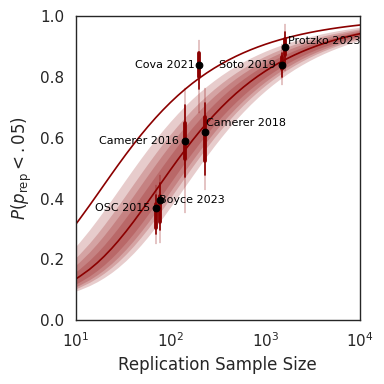

In [24]:
sns.set_context('paper', font_scale=1.25)
sns.set_style('white')
#Helper functions for DRYer code
def plot_misc():
    plt.xlim(10, 10000)
    plt.ylim(0, 1)
    plt.xscale("log")
    plt.ylabel(r"$P(p_{\text{rep}} < .05)$")
    plt.xlabel("Replication Sample Size")

plt.figure(figsize=(4,4))

def label_jitter(label):
    if label == "OSC 2015":
        jitter = [-10, +0.02]
    elif label == "Boyce 2023":
        jitter = [300, +0.03]
    elif label == "Camerer 2016":
        jitter = [-20, 0]
    elif label == "Camerer 2018":
        jitter = [+1400, 0.03]
    elif label == "Protzko 2023":
        jitter = [+8500, +0.02]
    elif label == "Soto 2019":
        jitter = [-200, 0]
    elif label == "Cova 2021":
        jitter = [-20, 0.0]
    else:
        jitter = [0, 0]
    return jitter

#Calculate posterior predictive publication rate
tau = idata_rep_effort.posterior["var"].median(dim="paper")[:, ::5] 
sigma = np.repeat(0, tau.size) #OK to set to zero because we're working with pub rate
sigrate = lambda N: np.array(
    [publication_rate(t, s, 1, N) for t, s in zip(tau, sigma)]
).ravel() #Function so we avoid for loop
N = np.logspace(1, 4, 40).astype(int) #Sample sizes
y = [sigrate(item) for item in N] #Calculate the publication rate for each sample size

#Plot the median and quantiles
plt.plot(N, np.median(np.vstack(y),1), color="darkred", zorder=1)
for q in [0.03, 0.11, 0.25, 0.5]:
    low, high = np.quantile(np.vstack(y), [q / 2, 1 - q / 2], axis=1)
    plt.fill_between(N, low, high, alpha=0.2, color="darkred", lw=0, zorder=1)
plot_misc()



# Group by and annotate with the author_year, x as the median N, and y as the mean Sig
author_years = df["author_year"].unique()


for idx, group in enumerate(df.groupby("author_year")):
    pass
    post = idata_rep_effort.posterior_predictive["y"][:, :, group[1].index]

    # plt.scatter(np.sum(post,axis=2).median()/group[1].shape[0],idx,color='k')

    median_n = group[1]["n"].median()
    for q in [0.97, 0.89, 0.75, 0.5]:
        low = np.quantile(np.sum(post, axis=2), q) / group[1].shape[0]
        high = np.quantile(np.sum(post, axis=2), 1 - q) / group[1].shape[0]
        plt.plot(
            [median_n, median_n],
            [low, high],
            color="darkred",
            lw=(1 - q) * 11,
            zorder=2,
        )

    
    median = np.median(np.sum(post, axis=2)) / group[1].shape[0]
    # plt.plot([median, median], [idx-.5, idx+.5], color='k',lw=1)
    label = (
        group[1]["author_year"].values[0][:-4]
        + " "
        + group[1]["author_year"].values[0][-4:]
    )

    jitter = label_jitter(label)
    plt.text(
        median_n + jitter[0],
        median + jitter[1],
        label,
        ha="right",
        va="center",
        fontsize=8,
        color="k",
        zorder=3,
    )
    studies.append(group[0])

plt.scatter(
    df.groupby("author_year")["n"].median(),
    df.groupby("author_year")["Sig"].mean(),
    color="k",
    zorder=3,
)

# params
var = idata_rep_effort.posterior["var"].sel(paper="Cova2021").median() 
p_sig = publication_rate(var, 0, 1, N)
plt.plot(N, p_sig, color="darkred", ls="-")


plot_misc()
plt.tight_layout()
plt.savefig("./output/figures/SigVsSampleSize.png", dpi=300)

### Model Independent version 

28.0
10.0
13.0
21.0
34.0
35.0
63.0


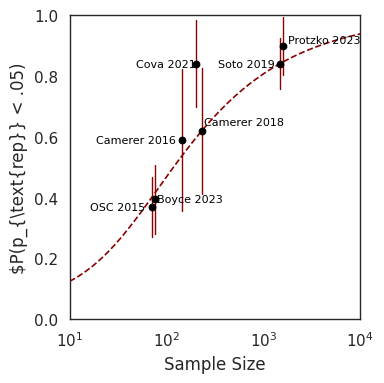

In [25]:
import statsmodels.api as sm


def binomial_confidence_interval(successes, trials, confidence=0.95):
    """
    Calculate the binomial confidence interval using statsmodels.

    Parameters:
    - successes: number of successes
    - trials: total number of trials
    - confidence: confidence level (default is 0.95)

    Returns:
    - Tuple containing the lower and upper bounds of the confidence interval
    """
    result = sm.stats.proportion_confint(successes, trials, alpha=1 - confidence)
    return result


plt.figure(figsize=(4, 4))

# params
d = 0.2
mean_effect = d * np.sqrt(np.pi / 2)
sigma = 0
tau = np.sqrt(mean_effect**2 - sigma**2)
N = np.logspace(1, 4, 100)

p_sig = publication_rate(tau, sigma, 1, N)
plt.plot(N, p_sig, label="Publication Rate", color="darkred", ls="--")

plt.xscale("log")
plt.ylim(0, 1)
plt.xlabel("Sample Size")
plt.ylabel(r"$P(p_{\text{rep}} < .05)")
plt.xlim(10, 10000)
plt.tight_layout()

for idx, group in enumerate(df.groupby("author_year")):
    pass
    post = idata_rep_effort.posterior_predictive["y"][:, :, group[1].index]

    # plt.scatter(np.sum(post,axis=2).median()/group[1].shape[0],idx,color='k')

    median_n = group[1]["n"].median()

    successes = group[1]["Sig"].sum()
    print(successes)
    trials = group[1].shape[0]
    low, high = binomial_confidence_interval(successes, trials)
    plt.plot([median_n, median_n], [low, high], color="darkred", lw=1, zorder=2)
    plt.scatter(median_n, successes / trials, color="k", zorder=3)
    median = np.median(np.sum(post, axis=2)) / group[1].shape[0]
    # plt.plot([median, median], [idx-.5, idx+.5], color='k',lw=1)
    label = (
        group[1]["author_year"].values[0][:-4]
        + " "
        + group[1]["author_year"].values[0][-4:]
    )
    if label == "OSC 2015":
        jitter = [-10, +0.02]
    elif label == "Boyce 2023":
        jitter = [300, +0.03]
    elif label == "Camerer 2016":
        jitter = [-20, 0]
    elif label == "Camerer 2018":
        jitter = [+1400, 0.03]
    elif label == "Protzko 2023":
        jitter = [+8500, +0.02]
    elif label == "Soto 2019":
        jitter = [-200, 0]
    elif label == "Cova 2018":
        jitter = [-20, 0.0]
    else:
        jitter = [0, 0]
    plt.text(
        median_n + jitter[0],
        median + jitter[1],
        label,
        ha="right",
        va="center",
        fontsize=8,
        color="k",
        zorder=3,
    )
    studies.append(group[0])

plt.tight_layout()
plt.savefig("./output/figures/ModelIndependentRepSig.png", dpi=300)


# ML 5 

## Load Data 

In [26]:
tables = tabula.read_pdf("dat/ML5.pdf", pages="all")


Got stderr: Jun 07, 2024 10:40:38 AM org.apache.pdfbox.pdmodel.font.PDFont loadUnicodeCmap
Jun 07, 2024 10:40:38 AM org.apache.pdfbox.pdmodel.font.PDFont loadUnicodeCmap
Jun 07, 2024 10:40:38 AM org.apache.pdfbox.pdmodel.font.PDFont loadUnicodeCmap
Jun 07, 2024 10:40:38 AM org.apache.pdfbox.pdmodel.font.PDFont loadUnicodeCmap



In [27]:
rpp_median_n = np.median(
    tables[0]["Unnamed: 0"][2:].apply(lambda x: x.split(" ")[0])[::2].astype("int")
)
total_n = np.median(
    tables[0]["Unnamed: 1"][2:]
    .apply(lambda x: x.split(" ")[0].replace(",", ""))[::2]
    .astype("int")
    + tables[0]["Unnamed: 2"][2:]
    .apply(lambda x: x.split(" ")[0].replace(",", ""))[::2]
    .astype("int")
)
rpp_protocol_n = np.median(
    tables[0]["Unnamed: 1"][2:]
    .apply(lambda x: x.split(" ")[0].replace(",", ""))[::2]
    .astype("int")
)
rpp_revised_n = np.median(
    tables[0]["Unnamed: 2"][2:]
    .apply(lambda x: x.split(" ")[0].replace(",", ""))[::2]
    .astype("int")
)


In response to low observed rates of replicability in the Open Science Collaborations' 2015 paper, critics argued that the replications had failed due to ``bad faith'' replication. In response, a many-labs style replication effort was conducted using larger sample sizes, retesting 10 of the effects which had failed to achieve significance initially. Moreover, the authors subjected replication protocols to pre-peer review, creating revised protocols in order to test hypotheses surrounding bad faith. For the original and revised protocols, the observed rates of significance during replication were 1 and 2 studies respectively. A combined meta-analysis indicated four of the six studies were significant. The authors' combined meta-analytic estimate included both the original study and the original replication. Using their provided code and data (https://osf.io/8nmga/), we verified four were significant even if the original two studies are excluded. 

To examine these results in the context of our statistical model requires a some algebra. For simplicity, we refer to the probability of significance at a lower sample size($N_l$) as $p_l=\text{Pr}(p<.05 \mid N=N_l)$, and at a higher sample ($N_h$) size as $p_l=\text{Pr}(p<.05 \mid N=N_h)$. Each of these can be calculated using our model and either the posterior estimate of $v$ and the median replication sample size. Increasing the sample size, we expect the absolute change in replicability to increase by $p_h - p_l$. This is the additional proportion of the total replication effort expected to achieve significance on replication. However, as the sampling frame is only among the initially non-significant replications we need to take this into account. We can do so by multiplying this quantity by the proportion of replications which fail to achieve significance at $N_l$:

\begin{align}
Pr(P<.05) = (p_h - p_l) * (1-p_l)
\end{align}

The gives us the expected proportion of non-significant finding expected to achieve significance when replicated at a larger sample size. We can simulate the number of observed replications using our posterior estimate of $v$ from our statistical model described above. Using the literature-wide estimate, or the OSC 2015 estimate we find that the observed rates of replication are well-within what would be expected given variation in sample size alone(Fit. \ref{sifig:ML5}).

Expected rate:
2.0
94% CR
0.0 5.0
Expected rate:
2.0
94% CR
0.0 5.0
Expected rate:
2.0
94% CR
0.0 5.0
Expected rate:
3.0
94% CR
1.0 6.0
Expected rate:
2.0
94% CR
0.0 5.0
Expected rate:
3.0
94% CR
0.0 5.029999999998836


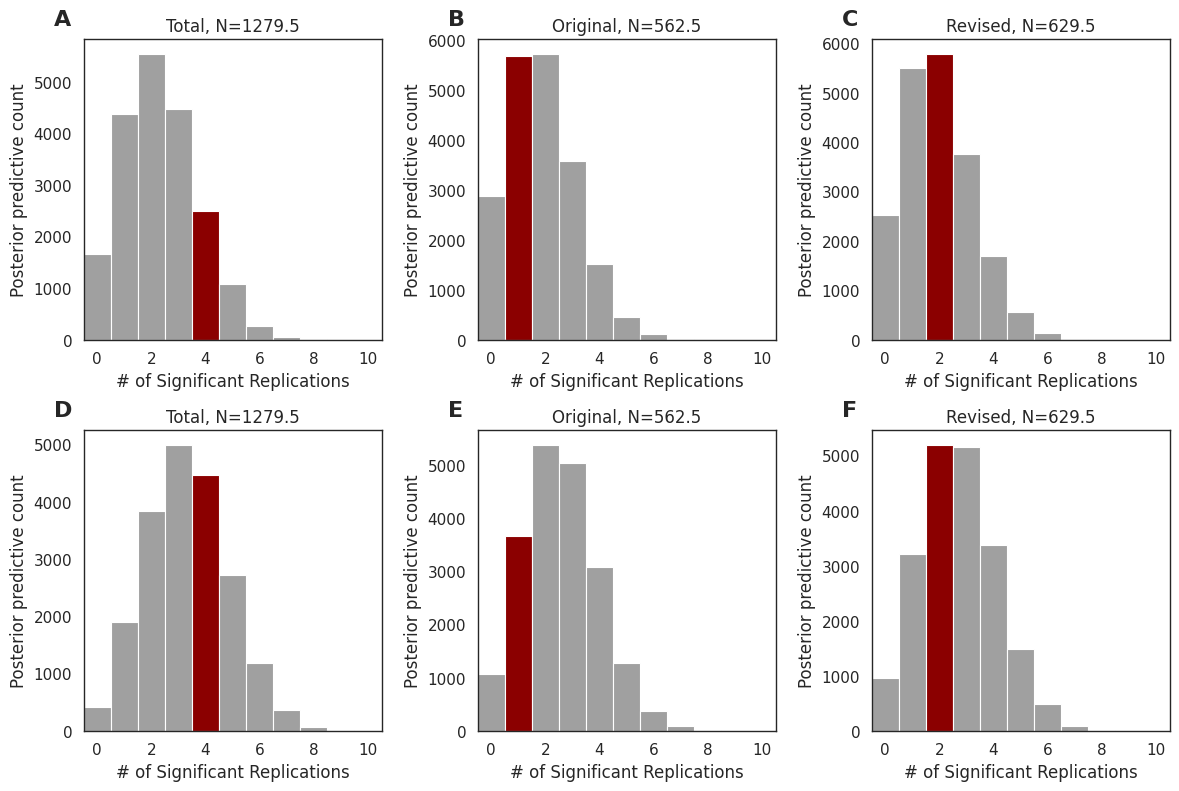

In [28]:
# Calculate key parameters
sig = 0.09
tau = np.sqrt(idata_rep_effort.posterior["var"].median(axis=2).values ** 2 - sig**2)
sigma = np.repeat(sig, tau.size)

# Create a labmda function to calculate the rate of significance
sigrate = lambda N: np.array(
    [publication_rate(t, s, 1, N) for t, s in zip(tau, sigma)]
).ravel()

# Create a figure with 3 subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
observed = [4, 1, 2]

ax = axs[0]

# Precalculate the rate of significance for the total sample size
y2 = sigrate(71)

# List of subplot titles
title = ["Total", "Original", "Revised"]

# Loop through the subsample sizes and calculate the rate of significance
# Then plot the posterior predictive distribution of the number of significant replications
for idx, size in enumerate([total_n, rpp_protocol_n, rpp_revised_n]):
    plt.sca(ax[idx])

    # Calculate the expected rate of significance and the marginal gain, then multiply by the rate of non-significance
    y1 = sigrate(size)
    y = (y1 - y2) * (1 - y2)

    # Binomial simulation from the posterior predictive distribution
    draws = np.random.binomial(10, y)

    # Print the expected rate and the 94% CR
    print("Expected rate:")
    print(np.median(draws))
    print("94% CR")
    low = np.quantile(draws, 0.03)
    high = np.quantile(draws, 0.97)
    print(low, high)

    # Plot the histogram
    plt.title(title[idx] + ", N=" + str(size))
    # pretty histogram
    sns.histplot(
        np.random.binomial(10, y), bins=np.linspace(-0.5, 10.5, 12), color="grey"
    )
    # Recolor the observed bar
    plt.gca().patches[observed[idx]].set_facecolor("darkred")

    # Set the x and y limits, and label the axes
    plt.xlim(-0.5, 10.5)
    plt.xlabel("# of Significant Replications")
    plt.ylabel("Posterior predictive count")


# Calculate key parameters, this time for OSC specifically
sig = 0.09
tau = np.sqrt(
    idata_rep_effort.posterior["var"].sel(paper="OSC2015").values ** 2 - sig**2
)  # Note, this line does all the work
sigma = np.repeat(sig, tau.size)

# Create a labmda function to calculate the rate of significance
sigrate = lambda N: np.array(
    [publication_rate(t, s, 1, N) for t, s in zip(tau, sigma)]
).ravel()


# Set axes to bottom row
ax = axs[1]
# Precalculate the rate of significance for the total sample size
y2 = sigrate(71)

# List of subplot titles
title = ["Total", "Original", "Revised"]

# Loop through the subsample sizes and calculate the rate of significance
# Then plot the posterior predictive distribution of the number of significant replications
for idx, size in enumerate([total_n, rpp_protocol_n, rpp_revised_n]):
    plt.sca(ax[idx])

    # Calculate the expected rate of significance and the marginal gain, then multiply by the rate of non-significance
    y1 = sigrate(size)
    y = (y1 - y2) * (1 - y2)

    # Binomial simulation from the posterior predictive distribution
    draws = np.random.binomial(10, y)

    # Print the expected rate and the 94% CR
    print("Expected rate:")
    print(np.median(draws))
    print("94% CR")
    low = np.quantile(draws, 0.03)
    high = np.quantile(draws, 0.97)
    print(low, high)

    # Plot the histogram
    plt.title(title[idx] + ", N=" + str(size))
    # pretty histogram
    sns.histplot(
        np.random.binomial(10, y), bins=np.linspace(-0.5, 10.5, 12), color="grey"
    )
    # Recolor the observed bar
    plt.gca().patches[observed[idx]].set_facecolor("darkred")

    # Set the x and y limits, and label the axes
    plt.xlim(-0.5, 10.5)
    plt.xlabel("# of Significant Replications")
    plt.ylabel("Posterior predictive count")

plt.tight_layout()
# label each subplot
ax = axs.flatten()
for i, label in enumerate(["A", "B", "C", "D", "E", "F"]):
    ax[i].text(
        -0.1,
        1.1,
        label,
        transform=ax[i].transAxes,
        fontsize=16,
        fontweight="bold",
        va="top",
    )


plt.savefig("./output/figures/ML5Supplement.png")


# Scheel and Lakens 

In [29]:
idata_rep_effort.sel(paper="OSC2015").posterior["var"].values.ravel()


array([0.18318902, 0.20146818, 0.17214625, ..., 0.23170488, 0.21236749,
       0.21659612])

In [30]:
data_scheel = pd.read_csv('./dat/ScheelLakensRRWithN.csv')
sample_sizes = pd.to_numeric(data_scheel['N'], errors='coerce')
N_SL = np.round(sample_sizes.dropna().median())


In [31]:
sigma = 0.07  # Average sigma from our two estimates
X = idata_rep_effort.sel(paper="OSC2015").posterior["var"].values.ravel()


def pub_func(x):
    tau = np.sqrt(x**2 - sigma**2)
    return publication_rate(tau=tau, sig=sigma, eps=1, n=N_SL) #Median N from 


sig = multiprocess_N(
    pub_func, idata_rep_effort.posterior["var"].median(dim="paper").values.ravel()
)

print("Median sig")
print(np.median(sig))
print("94% CR")
print(np.quantile(sig, [0.03, 0.97]))


Median sig
0.5353034423712624
94% CR
[0.42600359 0.66562322]


# Protzko 2023 

In [32]:
# Open File
df_protzko = pd.read_csv("dat/Protzko2023.csv")

# Calculate full sample size
df_protzko["ne"] = df_protzko["n2750e"] + df_protzko["n1750e"]
df_protzko["nc"] = df_protzko["n2750c"] + df_protzko["n1750c"]
# Calculate variance
v_basic = (
    1 / df_protzko["ne"]
    + 1 / df_protzko["ne"]
    + df_protzko["d"] ** 2 / (2 * (df_protzko["N"] - 2))
)

# Loop through, using methods provided by Protko et all for estimating p-values.
temp = []
for idx in range(v_basic.shape[0]):
    if np.isnan(df_protzko["sefull"].iloc[idx]):
        temp.append(v_basic.iloc[idx])
    else:
        temp.append(df_protzko["sefull"].iloc[idx] ** 2)
df_protzko["v"] = temp
df_protzko["pval"] = 2 * (1 - norm.cdf(abs(df_protzko["d"] / np.sqrt(df_protzko["v"]))))


### Significance for confirmatory 

In [33]:
originals = df_protzko[df_protzko["confirmation"] == 1]
print("Rate of significance in original studies")
print(str((originals["pval"] < 0.05).sum()) + " of " + str(originals.shape[0]))

# Simulate significance for originals
def pub_func(x):
    tau = np.sqrt(x**2 - sigma**2)
    return publication_rate(tau=tau, sig=sigma, eps=1, n=originals["N"].median())


sig_orig = multiprocess_N(
    pub_func, idata_rep_effort.posterior["var"].median(dim="paper").values.ravel()
)
sig_orig_sim = np.random.binomial(originals.shape[0], sig_orig)
print("Simulated:")
print("Median: " + str(np.median(sig_orig_sim)))
print("94% CR: " + str(np.quantile(sig_orig_sim, [0.03, 0.97])))


Rate of significance in original studies
13 of 16
Simulated:
Median: 14.0
94% CR: [11. 16.]


In [34]:
### Significance for AllReplications
# Total significance for replications.
reps = df_protzko[df_protzko["confirmation"] == 0]
print("Rate of significance in replication studies")
print(str((reps["pval"] < 0.05).sum()) + " of " + str(reps.shape[0]))

# Simulate significance for replications
def pub_func(x):
    tau = np.sqrt(x**2 - sigma**2)
    return publication_rate(tau=tau, sig=sigma, eps=1, n=reps["N"].median())


sig_rep = multiprocess_N(
    pub_func, idata_rep_effort.posterior["var"].median(dim="paper").values.ravel()
)
sig_rep_sim = np.random.binomial(reps.shape[0], sig_rep)
print("Simulated:")
print("Median: " + str(np.median(sig_rep_sim)))
print("94% CR: " + str(np.quantile(sig_rep_sim, [0.03, 0.97])))


Rate of significance in replication studies
54 of 64


Simulated:
Median: 55.0
94% CR: [48. 60.]


### Independent replications of significant confirmatory studies 

In [35]:
# #Identify studies for which the confirmation is significant, drop those.
originals = df_protzko[df_protzko["confirmation"] == 1]
studies_to_drop = originals[originals["pval"] > 0.05]["study"]
df_protzko = df_protzko[~df_protzko["study"].isin(studies_to_drop)]

# Include only independent replications.
df_protzko = df_protzko[df_protzko["selfrep"] == 0]
df_protzko = df_protzko[df_protzko["confirmation"] == 0]


def rep_func(x):
    sigma = 0.07  # From linden
    tau = np.sqrt(x**2 - sigma**2)
    return replicate_rate(tau=tau, sig=sigma, eps=1, n=df_protzko["N"].median())


rep_rep = multiprocess_N(
    rep_func, idata_rep_effort.posterior["var"].median(dim="paper").values.ravel()
)
rep_rep_sim = np.random.binomial(df_protzko.shape[0], rep_rep)
print("Simulated rep:")
print("Median: " + str(np.median(rep_rep_sim)))
print("94% CR: " + str(np.quantile(rep_rep_sim, [0.03, 0.97])))


Simulated rep:
Median: 34.0
94% CR: [29. 37.]


In [36]:
X = idata_rep_effort.posterior["var"].median(dim="paper").values.ravel()


def sign_func2(x):
    sigma = 0.07
    tau = np.sqrt(x**2 - sigma**2)
    return sign_error2(tau=tau, sig=sigma, eps=1, n=df_protzko["N"].median())


sign = multiprocess_N(sign_func2, X)


sign = np.random.binomial(39, sign)
print("Median sig")
print(np.median(sign))
print("94% CR")
print(np.quantile(sign, [0.03, 0.97]))


/home/joseph/anaconda3/envs/rep_surveys/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/joseph/anaconda3/envs/rep_surveys/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/joseph/anaconda3/envs/rep_surveys/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/joseph/anaconda3/envs/rep_surveys/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_o

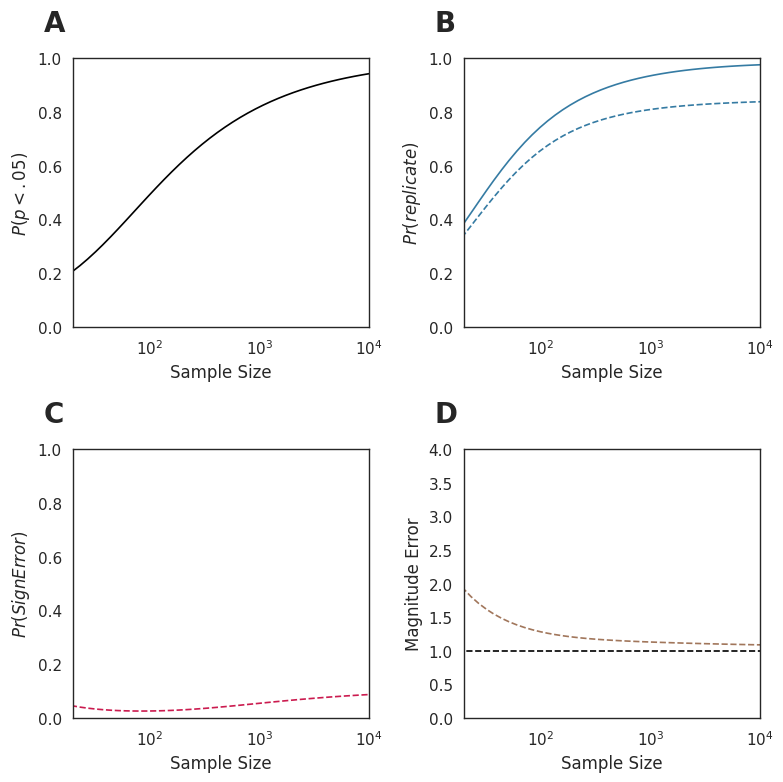

In [ ]:
from src.theory_sims import *
import string

sns.set_context("paper", font_scale=1.25)
sns.set_style("white")


def plot_fun_temp():
    # logscale x
    plt.xscale("log")
    plt.xlim(10, 10000)
    plt.ylim(0, 1)
    plt.xlabel("Sample Size")
    # natural units
    # plt.xticks([10, 100, 1000, 10000], [10, 100, 1000, 10000])


# Define multiprocessing functions
def rep_func(x):
    return replicate_rate(tau=tau, sig=sigma, eps=1, n=x)


def sign_func(x):
    return sign_error(tau=tau, sig=sigma, eps=1, n=x)


def mag_func(x):

    return magnitude_error(tau=tau, sig=sigma, eps=1, n=x)


X = idata_rep_effort.posterior["var"].median()

n_sim = np.logspace(1.3, 4, 40).astype(int)
# gridspec 2x2
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
# ravel ax
ax = ax.ravel()
plt.sca(ax[0])
ls_list = ["-", "--", "-.", ":"]
sigma = 0.09
tau = np.sqrt(X**2 - sigma**2)


def pub_func(x):
    return publication_rate(tau=tau, sig=sigma, eps=1, n=x)


sig = multiprocess_N(pub_func, n_sim)
plt.plot(n_sim, sig, color="k")

plot_fun_temp()
plt.ylabel(r"$P(p < .05)$")

plt.sca(ax[1])
labels = ["Protzko Et al 2023 (.07)", "Linden and Hönekopp (.09)"]
X = idata_rep_effort.posterior["var"].median()
cmap = sns.color_palette("mako", n_colors=3)
for idx, sigma in enumerate([0.01, 0.09]):
    tau = np.sqrt(X**2 - sigma**2)

    def rep_func(x):
        return replicate_rate(tau=tau, sig=sigma, eps=1, n=x)

    sig = multiprocess_N(rep_func, n_sim)
    plt.plot(n_sim, sig, ls=ls_list[idx], color=cmap[1], label=labels[idx])
    # logscale x
    plt.xscale("log")

plot_fun_temp()
plt.ylabel(r"$Pr(replicate)$")

plt.sca(ax[2])
cmap = sns.color_palette("rocket", n_colors=3)
sigma = 0.09
tau = np.sqrt(X**2 - sigma**2)


def sign_func(x):
    return sign_error(tau=tau, sig=sigma, eps=1, n=x)


rep = multiprocess_N(sign_func, n_sim)
plt.plot(n_sim, rep, ls=ls_list[idx], c=cmap[idx], label=labels[idx])
# logscale x
plt.xscale("log")

plot_fun_temp()
plt.ylabel(r"$Pr(Sign Error)$")

plt.sca(ax[3])
cmap = sns.color_palette("ch:start=1.3,rot=-.1", n_colors=3)
sigma = 0.09
tau = np.sqrt(X**2 - sigma**2)


def mag_func(x):
    return magnitude_error(tau=tau, sig=sigma, eps=1, n=x)


rep = multiprocess_N(mag_func, n_sim)
plt.plot(n_sim, rep, ls=ls_list[idx], c=cmap[idx], label=labels[idx])
# logscale x
plt.xscale("log")
plt.plot([10, 10000], [1, 1], color="k", ls="--")

# plot_fun_temp()
plt.ylabel("Magnitude Error")
plot_fun_temp()
plt.ylim(0, 4)
# label A-D

for n, ax in enumerate(ax.flatten()):
    ax.text(
        -0.1,
        1.1,
        string.ascii_uppercase[n],
        transform=ax.transAxes,
        size=20,
        weight="bold",
    )
    ax.set_xlim(20, 10000)

plt.tight_layout()
plt.savefig("./output/figures/TauSigmaSimsPsych.png", dpi=300)
